# QC

In [ ]:
import scanpy as sc
import numpy as np
import muon as mu
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Path
DATA_PATH = "/data/GEX"

# Additional functions
exec(open(f"/code/tools/clonal_tools.py").read())  # READ THROUGH ENTIRE CODE AND REMOVE MARK UNECESSARY PARTS OR USED PARTS!!!
sns.set_style("ticks")

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: 

In [2]:
def log1pPF(adata):
    adata_tmp = adata.copy()
    adata_tmp.layers["counts"] = adata_tmp.X.copy()
    sc.pp.normalize_total(adata_tmp)
    sc.pp.log1p(adata_tmp)
    sc.pp.highly_variable_genes(adata_tmp, n_top_genes=3000)
    adata_tmp.layers["scaled"] = sc.pp.scale(adata_tmp.X, max_value=10, copy=True)
    adata_tmp.obsm["X_pca"] = sc.pp.pca(adata_tmp[:, adata_tmp.var.highly_variable].layers["scaled"])
    sc.pp.neighbors(adata_tmp, n_pcs=30, n_neighbors=20)
    sc.tl.umap(adata_tmp)
    sc.tl.leiden(adata_tmp)
    
    return adata_tmp

In [ ]:
samples=["lens1",
        "lens2",
        "lens3",
        "otic1",
        "otic2",
        "olfac1",
        "olfac2",
        "112623_E11_cranial1",
        "112623_E11_cranial2",
        "112623_E11_Lens",
        "112623_E11_Olfactory",
        "112623_E11_Otic",]

In [ ]:
injections={"lens1":"E7.5",
            "lens2":"E7.5",
            "lens3":"E7.5",
            "otic1":"E7.5",
            "otic2":"E7.5",
            "olfac1":"E7.5",
            "olfac2":"E7.5",
            "112623_E11_cranial1":"E8.5",
            "112623_E11_cranial2":"E8.5",
            "112623_E11_Lens":"E7.5",
            "112623_E11_Olfactory":"E7.5",
            "112623_E11_Otic":"E7.5"}

In [ ]:
batches={"lens1":"injection33",
         "lens2":"injection33",
         "lens3":"injection33",
         "otic1":"injection33",
         "otic2":"injection33",
         "olfac1":"injection33",
         "olfac2":"injection33",
         "112623_E11_cranial1":"injection32",
         "112623_E11_cranial2":"injection32",
         "112623_E11_Lens":"injection31",
         "112623_E11_Olfactory":"injection31",
         "112623_E11_Otic":"injection31"}

In [ ]:
locations={"lens1":"lens",
           "lens2":"lens",
           "lens3":"lens",
           "otic1":"otic",
           "otic2":"otic",
           "olfac1":"olfactory",
           "olfac2":"olfactory",
           "112623_E11_cranial1":"cranial",
           "112623_E11_cranial2":"cranial",
           "112623_E11_Lens":"lens",
           "112623_E11_Olfactory":"olfactory",
           "112623_E11_Otic":"otic"}

In [5]:
sample=samples[0]

In [ ]:
description = {
    "sample_id" : sample,
    "batch" : batches[sample],
    "FPs" : ["TOMbc"],
    "plasmids" : ["pMR671"],
    "location" : locations[sample],
    "devtime" : "E11.5", 
    "injections" : [injections[sample]], 
    "CRISPR": False,
}

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


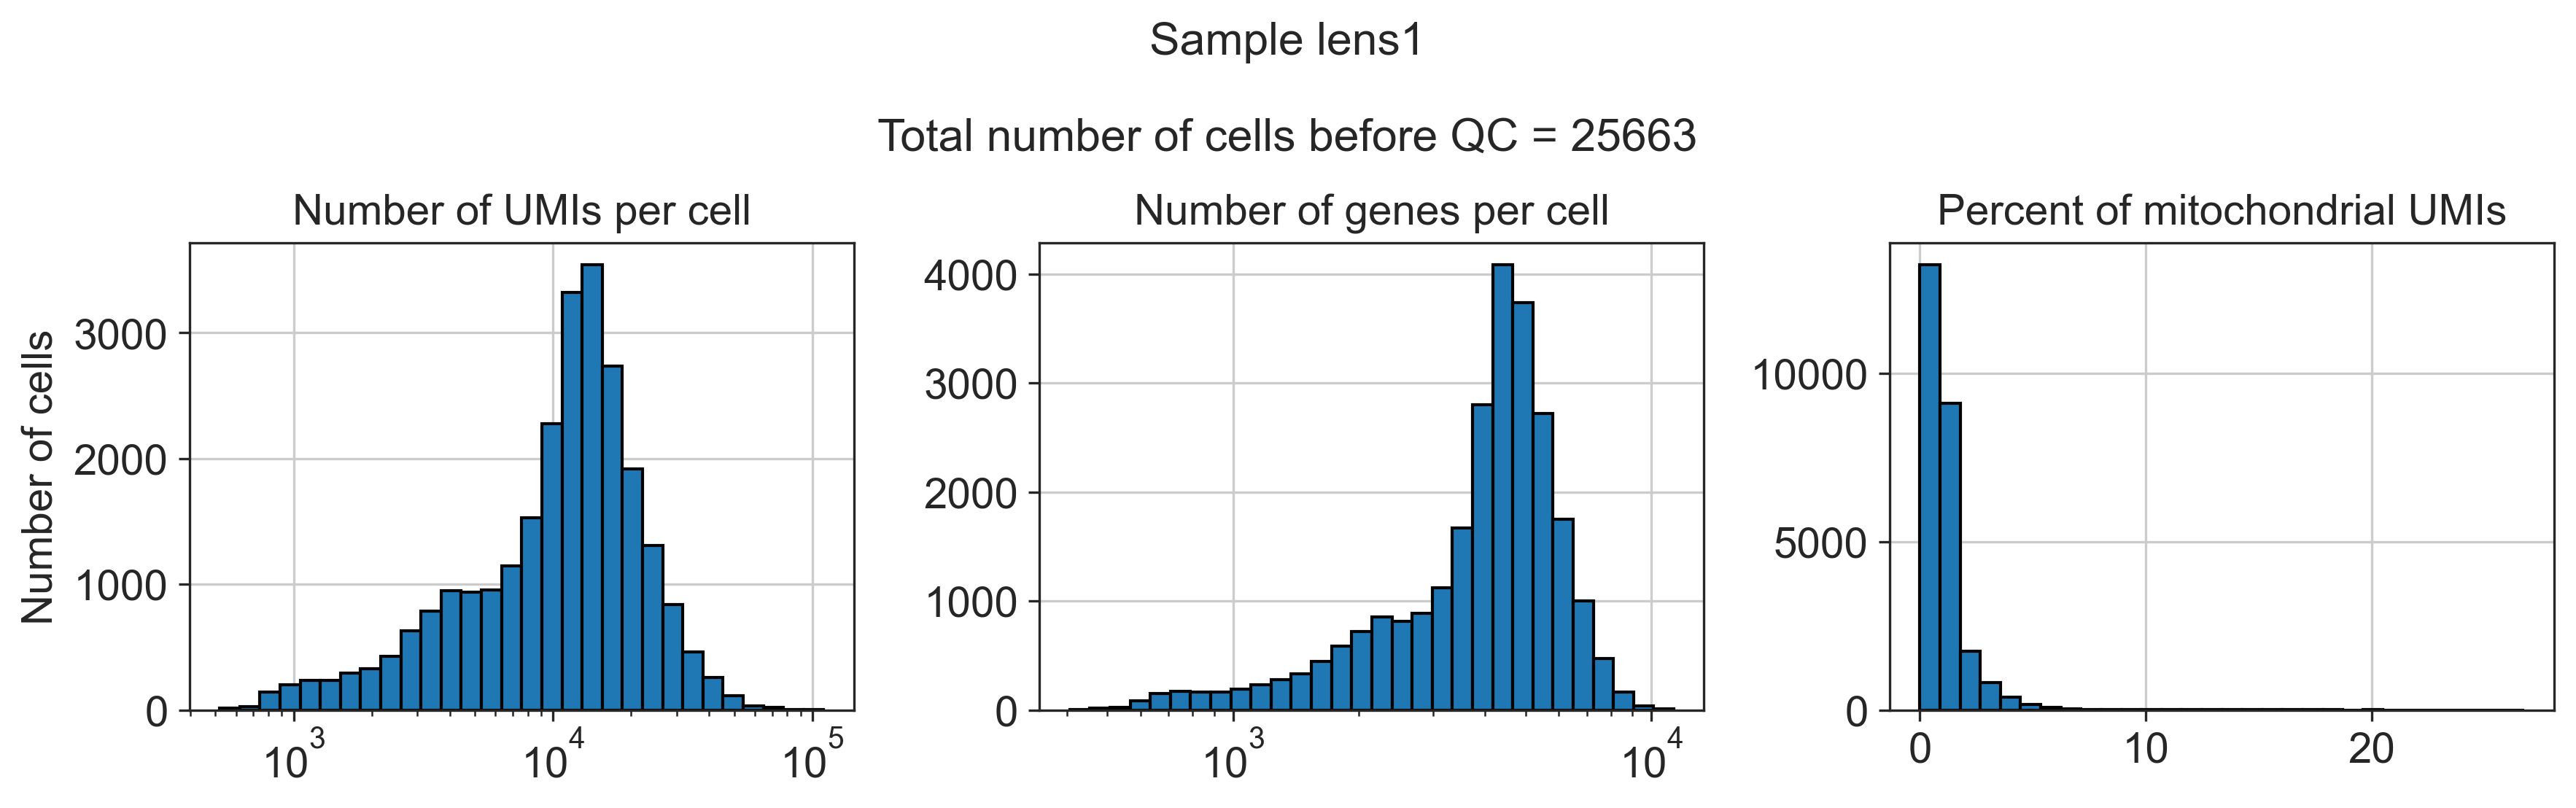

In [ ]:
sample = description["sample_id"]

# GEX
adata = sc.read_10x_h5(f"{DATA_PATH}/cellranger/{sample}/{sample}_filtered_feature_bc_matrix.h5") ####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
adata.obs.index = [sample + ":" + bc.split("-")[0] for bc in adata.obs.index]
adata.obs["batch"] = description["batch"]
adata.obs["sample_id"] = description["sample_id"]
adata.obs["location"] = description["location"]
adata.obs["devtime"] = description["devtime"]
adata.obs["plasmids"] = " + ".join(description["plasmids"])
adata.obs["injection"] = " + ".join(description["injections"])
    
# QC
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None, log1p=False, qc_vars=["mt"])
qc_plot = draw_counts_qc(adata, title=f"Sample {description['sample_id']}\n\nTotal number of cells before QC = {len(adata)}")  ####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
adata_prefiltered = adata.copy()

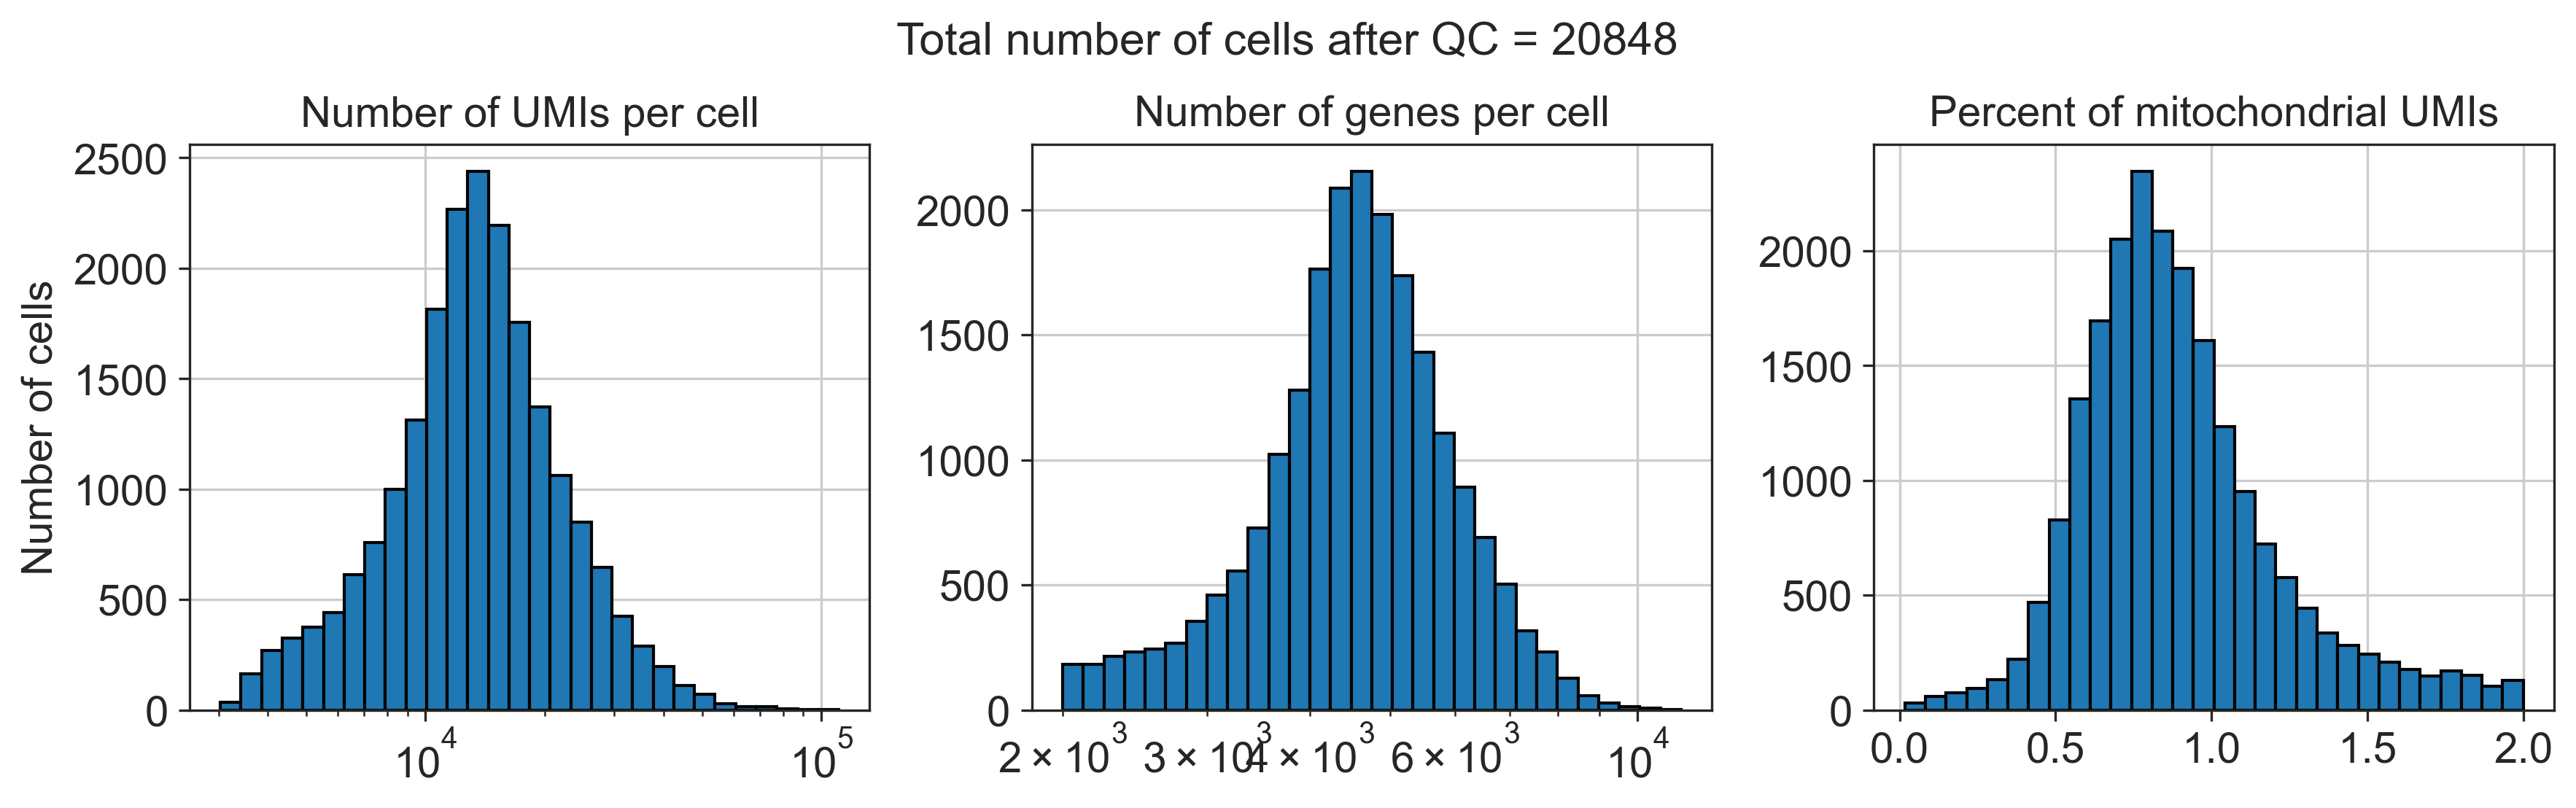

In [8]:
min_umi = 2000
min_genes = 2000
mt_max = 2

adata_tmp = adata.copy()
adata_tmp = adata_tmp[
    (adata_tmp.obs.total_counts >= min_umi) &
    (adata_tmp.obs.pct_counts_mt <= mt_max) &
    (adata_tmp.obs.n_genes_by_counts >= min_genes)
]

qc_plot = draw_counts_qc(adata_tmp, title=f"Total number of cells after QC = {len(adata_tmp)}")

In [9]:
adata = adata[adata_tmp.obs_names]

In [10]:
adatas_FP = {}
FP = description["FPs"][0]
from scipy.sparse import vstack, hstack, csr_matrix


In [11]:
# My slighlty modified vesion for the new data 

adatas_FP[FP] = sc.read_csv(f"{DATA_PATH}/trex/{sample}/TOMbc/umi_count_matrix.csv")
adatas_FP[FP] = adatas_FP[FP].T
adatas_FP[FP].obs.index = [sample + ":" + bc for bc in adatas_FP[FP].obs.index]
adatas_FP[FP] = adatas_FP[FP][np.isin(adatas_FP[FP].obs_names, adata.obs_names)]
empty_cells = adata.obs_names[~np.isin(adata.obs_names, adatas_FP[FP].obs_names)]
adatas_FP[FP] = sc.AnnData(
        X=vstack([adatas_FP[FP].X, csr_matrix(np.zeros((len(empty_cells), len(adatas_FP[FP].var_names))))], "csr"),
        obs=pd.DataFrame(index=(list(adatas_FP[FP].obs_names) + list(empty_cells))),
        var=adatas_FP[FP].var)
adatas_FP[FP] = adatas_FP[FP][adata.obs_names]
adatas_FP[FP].X[(adatas_FP[FP].X <= 1).toarray()] = 0
adatas_FP[FP] = adatas_FP[FP][:, adatas_FP[FP].X.sum(axis=0).A[0] > 0]


/tmp/ipykernel_20396/4046470856.py:13: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using <= is inefficient, try using > instead.
  adatas_FP[FP].X[(adatas_FP[FP].X <= 1).toarray()] = 0
/tmp/ipykernel_20396/4046470856.py:13: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  adatas_FP[FP].X[(adatas_FP[FP].X <= 1).toarray()] = 0
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


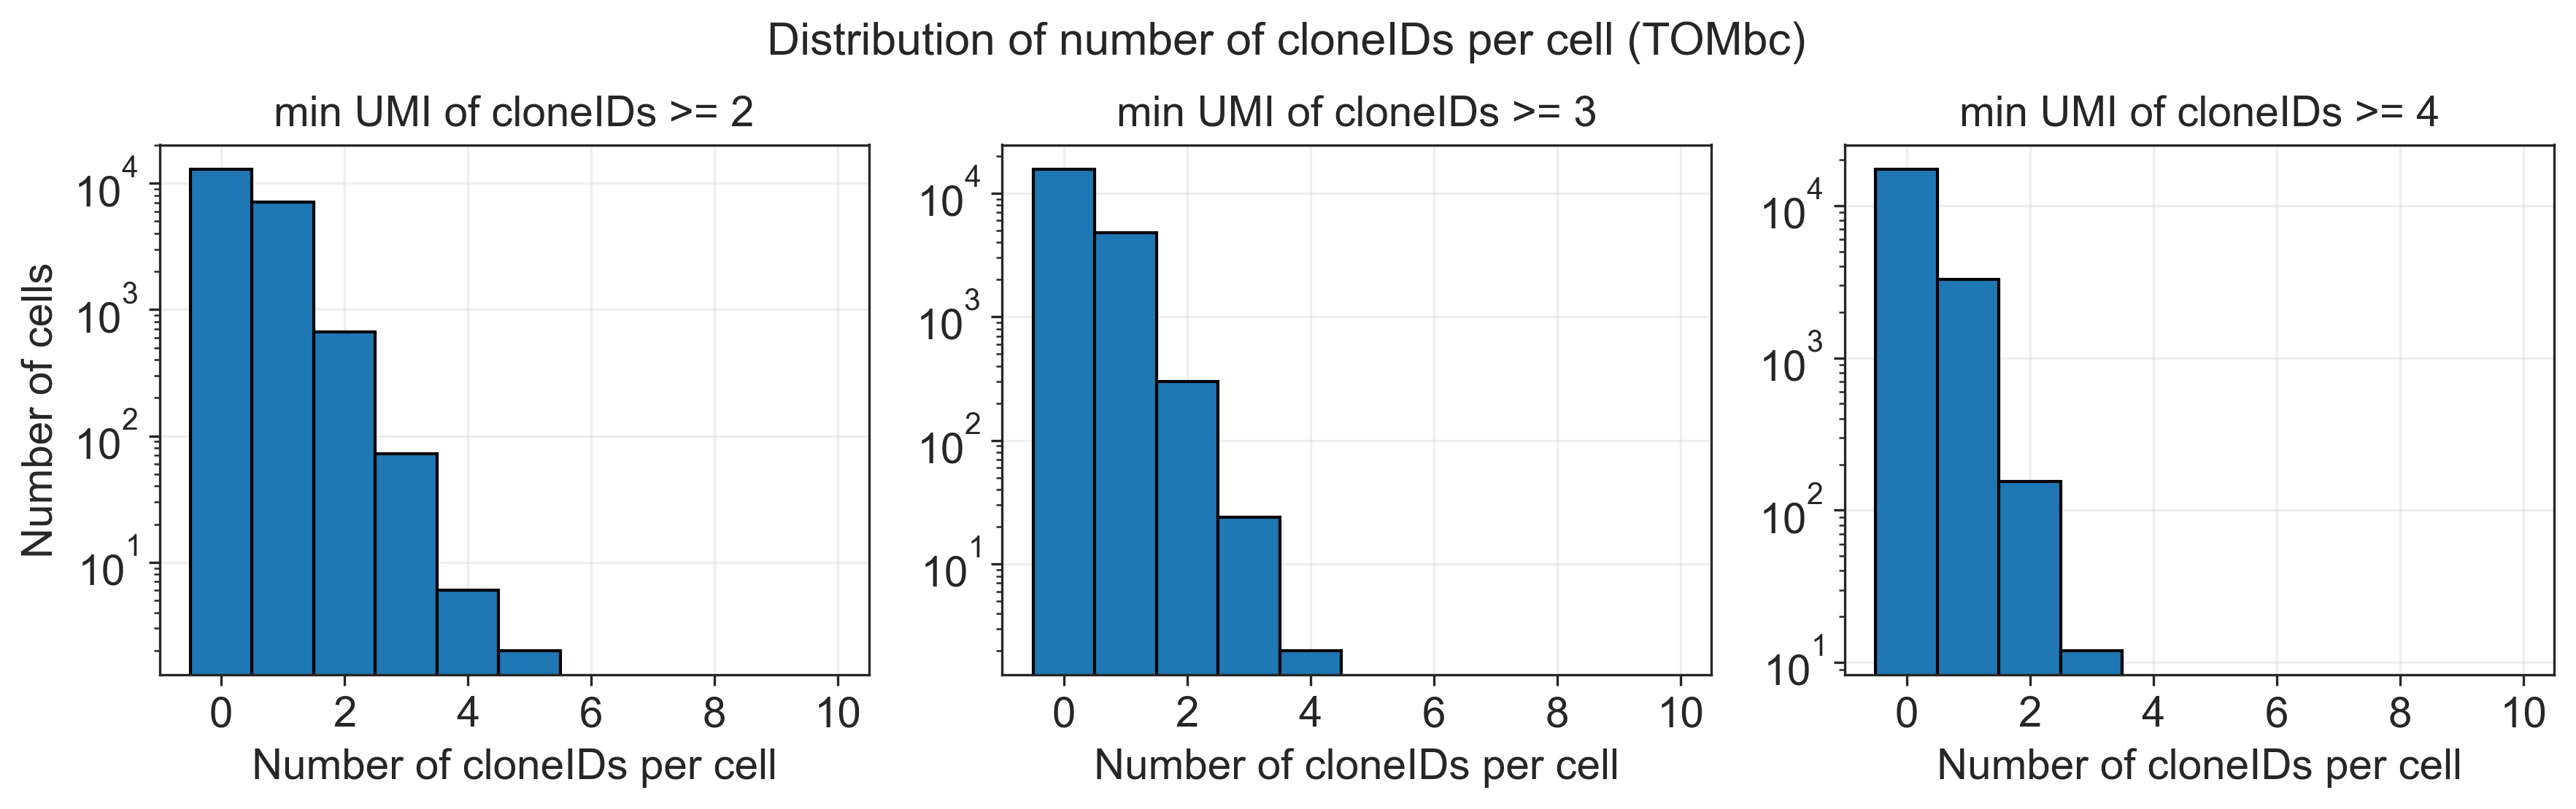

In [12]:
# What this means is IF we set a threshold of minimum UMI of a clone ID to 
# count as a clone id, what would the distriubtion be?
# Similar to us removing all only present one time. 
if len(adatas_FP) == 2:
    adatas_FP_clear = resolve_confusion(adatas_FP)
    for FP in description["FPs"]:
        fig = draw_cloneID_QC(adatas_FP_clear[FP], FP)
else:
    fig = draw_cloneID_QC(adatas_FP[description["FPs"][0]], description["FPs"][0])

In [13]:
# This essentially sets the clone label for the cells
min_cloneID_umi = 2
if len(adatas_FP) == 2:
    FP1 = list(adatas_FP.keys())[0]
    FP2 = list(adatas_FP.keys())[1]

    FP1_clones = fast_clones(adatas_FP_clear[FP1], min_cloneID_umi=min_cloneID_umi)
    FP2_clones = fast_clones(adatas_FP_clear[FP2], min_cloneID_umi=min_cloneID_umi)
else:
    FP = list(adatas_FP.keys())[0]
    FP_clones = fast_clones(adatas_FP[FP], min_cloneID_umi=min_cloneID_umi)

In [14]:
# !!!!!!!
# Look at the QCs for the different samples!
# Normal threshold is 0.15
# For olfac2 I swtiched to 0.05
scrublet_threshold = 0.15
adata_final, adatas_FP_final = gex_qc_report(
    adata_prefiltered,
    adatas_FP,
    mt_name="mt-",
    mt_max=mt_max,
    savefig=f"QC_reports/{description['sample_id']}_GE.pdf",
    show=False,
    umi_min=min_umi,
    min_genes=min_genes,
    scrublet_threshold=scrublet_threshold,
    min_cloneID_umi=min_cloneID_umi,
)

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function scrublet is deprecated; Import from sc.pp instead
  warnings.warn(msg, category=FutureWarning)


<string>:610: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [15]:
for FP in description["FPs"]:
    del adata_final.obs[f"cloneID_multiplet_{FP}"]
if len(description["FPs"]) == 2:
    del adata_final.obs[f"cloneID_multiplet"]
if description["CRISPR"]:
    adata_final.obsm["CRISPR"] = adata[adata_final.obs_names].obsm["CRISPR"]
del(
    adata_final.var["n_cells_by_counts"],
    adata_final.var["mean_counts"],
    adata_final.var["pct_dropout_by_counts"],
    adata_final.var["total_counts"]
)
adata_final.uns["QC"] = {
    "mt_max": mt_max,
    "min_umi": min_umi,
    "min_genes": min_genes,
    "scrublet_threshold": scrublet_threshold,
}

In [16]:
adata_final.var_names_make_unique()
mdata = {"GEX": adata_final}
for FP in description["FPs"]:
    adatas_FP[FP].uns["QC"] = {"min_cloneID_umi": min_cloneID_umi}
    mdata[FP] = adatas_FP[FP]
mdata = mu.MuData(mdata)
mdata.update()
mdata.write_h5mu(f"{DATA_PATH}/anndatas_counts/{description['sample_id']}.h5mu")

/tmp/ipykernel_20396/3026985016.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adatas_FP[FP].uns["QC"] = {"min_cloneID_umi": min_cloneID_umi}
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and pus